In [1]:
# -*- coding: utf-8 -*-
# pylint: disable=invalid-name

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from spectral import *
import numpy as np
import scipy.spatial.distance as distance
import pylab
import spectral.io.envi as envi
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from timeit import default_timer as timer

In [4]:
from autoclustering import find_maxdist_clusters
from hiersubclustering import subdivide_by_modules
from visual_utils import show_classes, show_histogram, show_centers
from math_utils import cluster_histogram, normalized

Читаем изображение.

In [5]:
#img = open_image('92AV3C.lan')
# gt = open_image('92AV3GT.GIS').read_band(0)
img = envi.open('f080611t01p00r07rdn_c_sc01_ort_img.hdr')

In [6]:
print(img)

	Data Source:   '/home/marko/HSI/f080611t01p00r07rdn_c/f080611t01p00r07rdn_c_sc01_ort_img'
	# Rows:           1924
	# Samples:         753
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16


In [7]:
data = img[400:1000, 200:, :]
#data = img[400:700, 200:400, :]

In [8]:
data[data <= 0] = 1
print(data.dtype)

>i2


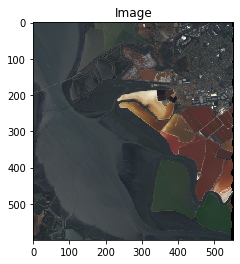

In [9]:
view = imshow(data, (29, 20, 12), title="Image")

In [ ]:
(class_map, centers) = find_maxdist_clusters(data, 0.9)
print('Centers\' shape: ', centers.shape)

In [ ]:
subclass_map = subdivide_by_modules(data, class_map, centers.shape[0], True)

In [ ]:
view = show_classes(subclass_map - 1)

In [ ]:
counts_per_clusters = cluster_histogram(centers, class_map)

In [ ]:
show_histogram(counts_per_clusters, 'Number of signatures per cluster')
show_centers(centers, "Final centers")

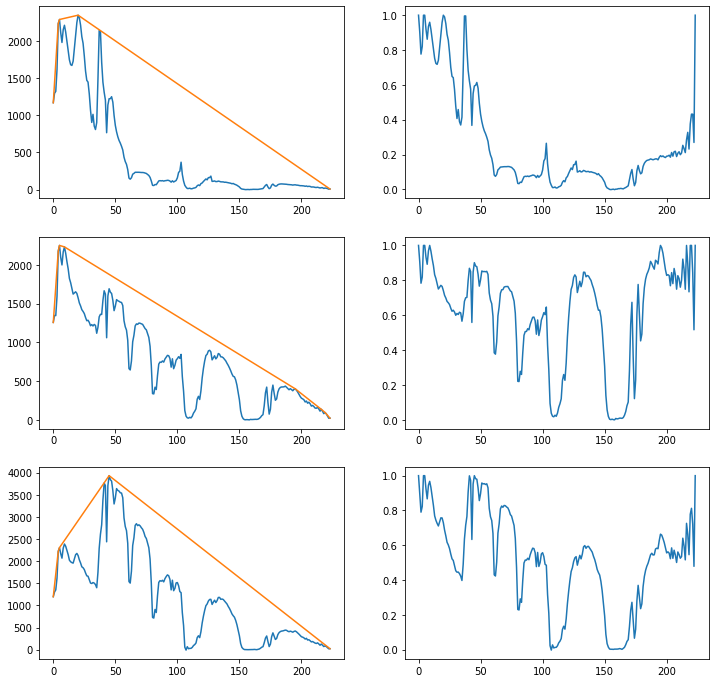

In [27]:
from continuum import continuum, continuum_removed
inarr = np.array([data[561, 501].astype(float), data[599, 3].astype(float), data[41, 525].astype(float)])
outarr = np.empty_like(inarr)
outarr_rem = np.empty_like(inarr)
continuum(inarr, outarr)
continuum_removed(inarr, outarr_rem)

fig = pylab.figure()
fig.set_size_inches(3*4, 2*6)

for i in range(3):
    pylab.subplot(3, 2, (i*2)+1)
    pylab.plot(inarr[i])
    pylab.plot(outarr[i])
    pylab.subplot(3, 2, (i*2)+2)
    pylab.plot(outarr_rem[i])

pylab.show()


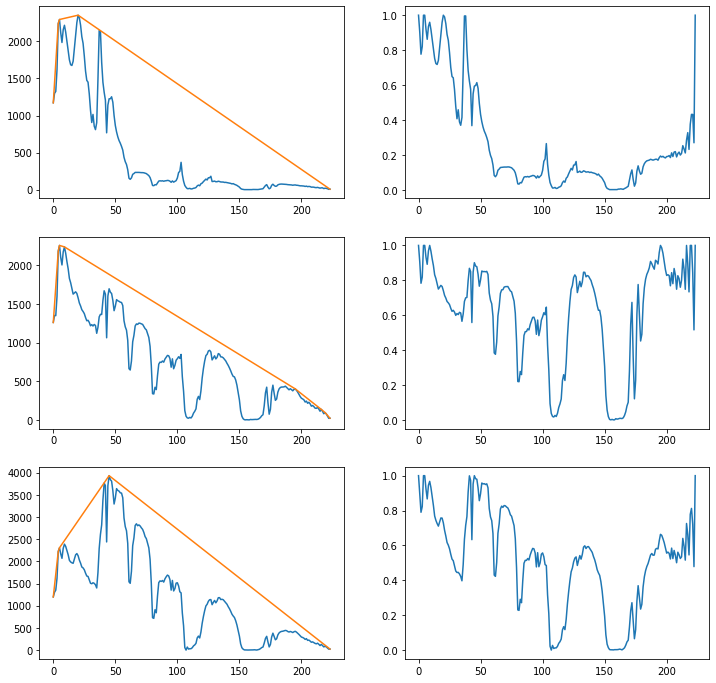

In [13]:
from pycontinuum import pycontinuum, pycontinuum_removed
inarr = np.array([data[561, 501].astype(float), data[599, 3].astype(float), data[41, 525].astype(float)])
outarr = np.empty_like(inarr)
outarr_rem = np.empty_like(inarr)

for i in range(0, inarr.shape[0]):
    pycontinuum(inarr[i], outarr[i])
    pycontinuum_removed(inarr[i], outarr[i], outarr_rem[i])

fig = pylab.figure()
fig.set_size_inches(3*4, 2*6)

for i in range(3):
    pylab.subplot(3, 2, (i*2)+1)
    pylab.plot(inarr[i])
    pylab.plot(outarr[i])
    pylab.subplot(3, 2, (i*2)+2)
    pylab.plot(outarr_rem[i])

pylab.show()